In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [4]:
train=pd.read_csv('energy/train.csv', encoding='cp949')
test=pd.read_csv('energy/test.csv', encoding='cp949')
submission=pd.read_csv('energy/sample_submission.csv', encoding='cp949')

In [5]:
train[['num', '비전기냉방설비운영','태양광보유']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'비전기냉방설비운영']
    hot[count]=train.loc[i,'태양광보유']
    
for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영']=ice[test['num'][i]]
    test.loc[i, '태양광보유']=hot[test['num'][i]]

In [6]:
def time(x):
    return int(x[-2:])
train['time']=train['date_time'].apply(lambda x: time(x))
test['time']=test['date_time'].apply(lambda x: time(x))

def weekday(x):
    return pd.to_datetime(x[:10]).weekday()
train['weekday']=train['date_time'].apply(lambda x :weekday(x))
test['weekday']=test['date_time'].apply(lambda x :weekday(x))

In [7]:
test.interpolate(method='values', inplace=True)

In [8]:
train['date_time'] = pd.to_datetime(train['date_time'].apply(lambda x: str(x)+':00'))
test['date_time'] = pd.to_datetime(test['date_time'].apply(lambda x: str(x)+':00'))

k: 2, inertia : 141731596052.6865
k: 3, inertia : 93263968980.8303
k: 4, inertia : 67366933376.6103
k: 5, inertia : 56459648679.0319
k: 6, inertia : 47063655777.2855
k: 7, inertia : 40041384909.0536
k: 8, inertia : 32744351078.3215
k: 9, inertia : 27965201748.6183
k: 10, inertia : 24313672662.1185


Text(0, 0.5, 'inertia')

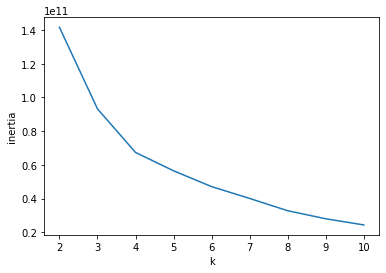

In [9]:
cluster_df = train['전력사용량(kWh)'].values.reshape(60, -1)

inertia_arr = []
k_arr = range(2, 11)

for k in k_arr:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(cluster_df)
    interia = kmeans.inertia_
    
    print('k: {0}, inertia : {1:.4f}'.format(k, interia))
    inertia_arr.append(interia)

plt.plot(k_arr, inertia_arr)
plt.xlabel('k')
plt.ylabel('inertia')

In [10]:
train_cluster_df = train['전력사용량(kWh)'].values.reshape(60, -1)

In [11]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans.fit(train_cluster_df)
clusters = kmeans.predict(train_cluster_df)

train_cluster_arr = []
for i in clusters.tolist():
    for j in range(2040):
        train_cluster_arr.append(i)

test_cluster_arr = []
for i in clusters.tolist():
    for j in range(168):
        test_cluster_arr.append(i)

train = pd.concat([train, pd.Series(train_cluster_arr, name='assignment')], axis=1)
test = pd.concat([test, pd.Series(test_cluster_arr, name='assignment')], axis=1)

In [12]:
def holiday(x):
    if str(x.date()) == '2020-06-06':
        return 1
    elif str(x.date()) == '2020-08-15':
        return 1
    elif x.weekday() == 5 or x.weekday() == 6:
        return 1
    else: 
        return 0

train['holiday'] = train['date_time'].apply(lambda x: holiday(x))
test['holiday'] = test['date_time'].apply(lambda x: holiday(x))

In [13]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday,assignment,holiday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,1,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,1,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,1,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,1,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,1,0


In [14]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday,assignment,holiday
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,0,1,1,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0,1,1,1,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0,2,1,1,0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,3,1,1,0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0.0,0.0,4,1,1,0


In [15]:
train.to_csv('edit_train.csv', index=False)
test.to_csv('edit_test.csv', index=False)